# Model Facts Example: Titanic
This notebook provides an end-to-end example from data to a Model Facts label using the Titanic dataset from https://www.kaggle.com/c/titanic/data

**The Problem**: Predicting survival of Titanic passengers 

**Solution**: Machine learning!

But what if decision makers were using this to understand how to allocate resources to improve chances of survival?

How can they trust the model? **Model Facts!**

In this notebook, we'll walk you through how you can go from a machine learning model to a model facts label through the following steps:

0. Setup
1. Data preprocessing
2. Model training
3. Model testing
4. *Create Model Facts label*
5. (bonus) deeper investigation

## 0. Setup
- Download the 'train.csv' and 'test.csv' from https://www.kaggle.com/competitions/titanic/data
- Load packages and data

In [1]:
# load packages
# ! pip install modelfacts
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
import matplotlib.pyplot as plt


from modelfacts.examples import preprocess as tpp
seed = 28 # set random seed

In [2]:
# read in data
filepath = '../data/titanic/train.csv'
train_df = pd.read_csv(filepath)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. Data Preprocessing
- extract additional features from the raw data
- fill in missing values
- split the Kaggle train data into our own modeling train and test sets

In [3]:
# clean data
train_df = tpp.preprocess_data(train_df)
train_df = tpp.impute_data(train_df)
# let's see how it changed
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_number,Ticket_item,Cabin_letter,Cabin_number
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,UNK,S,Mr.,21171.0,A/5,UNK,43.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,17599.0,PC,C,85.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,UNK,S,Miss.,3101282.0,STON/O2.,UNK,43.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,113803.0,UNK,C,123.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,UNK,S,Mr.,373450.0,UNK,UNK,43.0


In [4]:
# format data for modeling
y = train_df['Survived']
X = train_df.drop(
    ['Survived', 'Ticket', 'Name', 'PassengerId', 'Cabin'], 
    axis = 1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = .2, random_state = seed, shuffle = True)

## 2. Model Training
- Create pipeline objects for further data processing 
- We use a Decision Tree model for it's transparent characteristics
- Define the hyperparameter search criteria
- Call `fit` to train the model

In [5]:
# define model pipeline objects

# extract categories in train dataset for one hot encoding
cat_col = ['Sex', 'Embarked', 'Title', 'Ticket_item', 'Cabin_letter']
num_col = [col for col in X.columns if col not in cat_col]
categories = []
for col in cat_col:
    categories.append(list(set(train_df[col])))
 
enc = OneHotEncoder(
    handle_unknown = "ignore", categories = categories, 
    drop = 'first', min_frequency = 10, sparse_output = False) 
# rare categories get grouped together, 
# will drop the first category to avoid collinearity

scale = MinMaxScaler() # scale numerical values to between 0 and
model = tree.DecisionTreeClassifier(random_state =  seed)

In [6]:
# create model pipeline 
pipe = Pipeline([('features', FeatureUnion([
        ('numeric', tpp.Columns(names = num_col)),
        ('cat', make_pipeline(tpp.Columns(names = cat_col), enc))
        ])),
    ('model', model)])

In [7]:
# define hyperparameters to grid search over
param_grid = {'model__max_depth':[5,10,15],
    'model__max_leaf_nodes': [5,10,15], 
    'model__min_samples_split': [2,4,6]}
gridcv = GridSearchCV(pipe, param_grid, cv = 5, scoring = "accuracy", refit=True )

In [8]:
# train the model
gridcv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('numeric',
                                                                        Columns(names=['Pclass',
                                                                                       'Age',
                                                                                       'SibSp',
                                                                                       'Parch',
                                                                                       'Fare',
                                                                                       'Ticket_number',
                                                                                       'Cabin_number'])),
                                                                       ('cat',
                                                                        Pipeline(steps=[('columns',
                                                                                         Columns(names=['Sex',
                                                                                                        'Embarked',
                                                                                                        'Title',
                                                                                                        'Ticket_item',
                                                                                                        'Cabin_letter'])),
                                                                                        ('onehotencoder',
                                                                                         OneHotEncoder(categories=[['female',
                                                                                                                    'male'...
                                                                                                                    'S.O.C.',
                                                                                                                    'SCO/W',
                                                                                                                    'S.O.P.',
                                                                                                                    'CA.', ...],
                                                                                                                   ['T',
                                                                                                                    'F',
                                                                                                                    'G',
                                                                                                                    'D',
                                                                                                                    'F '
                                                                                                                    'G',
                                                                                                                    'C',
                                                                                                                    'B',
                                                                                                                    'E',
                                                                                                                    'F '
                                                                                                                    'E',
                                                                                                                    'UNK',
                                                                               

## 3. Model Testing
- Look at the results from model training (parameters, scores, visualization)
- Save predictions on the test set (used later in the Model Facts label)
- Save the baseline predictions 
- (Bonus): Save predictions on the Kaggle test set for competition submission

In [9]:
# let's see what the best hyperparameters were
gridcv.best_params_

{'model__max_depth': 10,
 'model__max_leaf_nodes': 15,
 'model__min_samples_split': 2}

In [10]:
# let's see what the mean cross validated score for those parameters
gridcv.best_score_

np.float64(0.8132867132867133)

In [11]:
# let's see what the score is on our full test set
gridcv.score(X_test, y_test)

0.8379888268156425

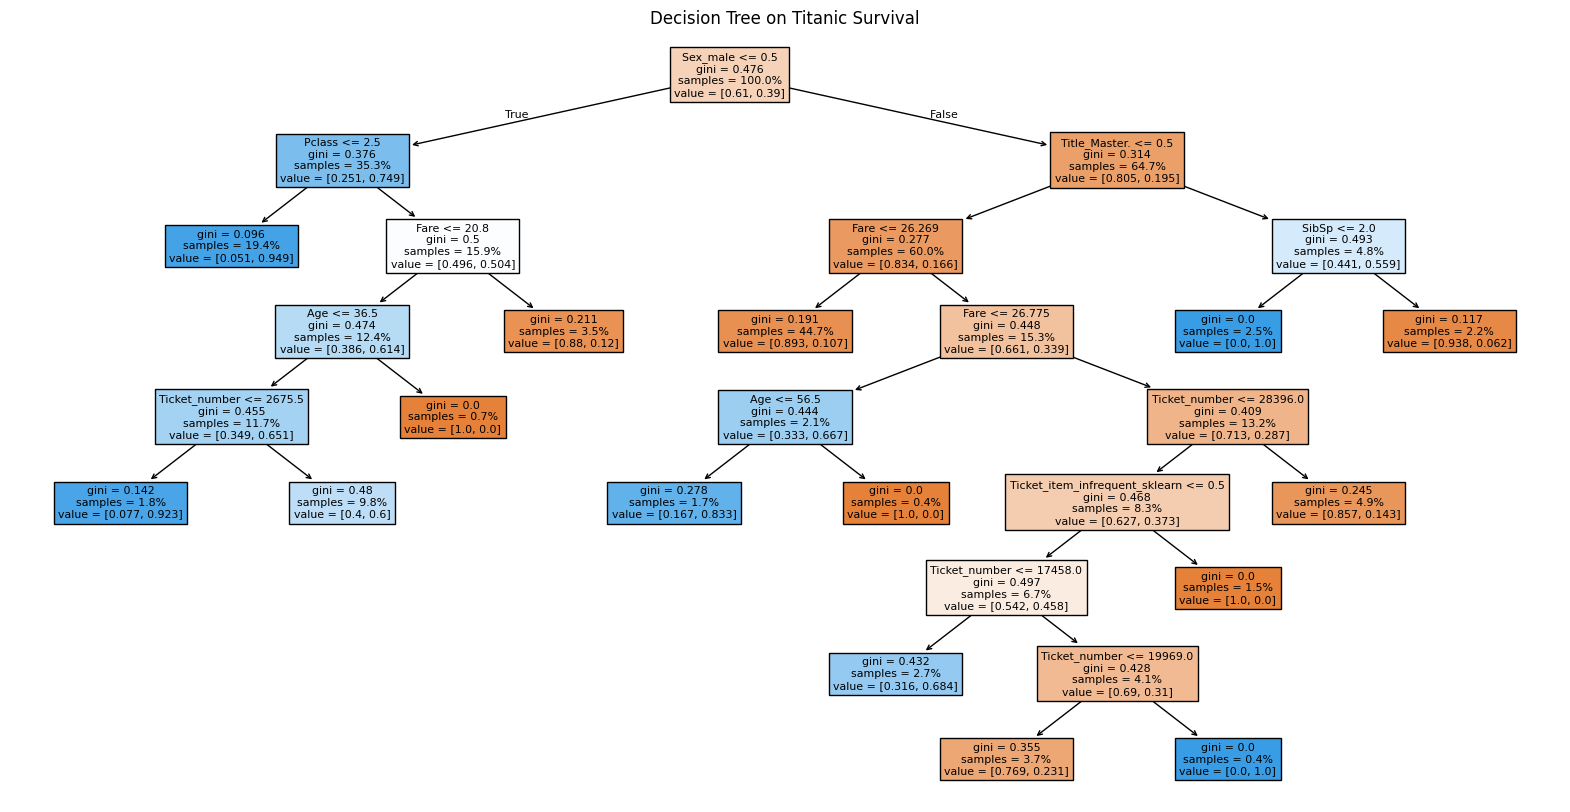

In [12]:
# let's generate the decision tree plot for the best model
new_cat_col = gridcv.best_estimator_['features']['cat'][1].get_feature_names_out(cat_col)
new_cols = num_col + list(new_cat_col)

plt.figure(figsize = (20,10))
tree.plot_tree(gridcv.best_estimator_['model'], feature_names = new_cols, 
    proportion = True, filled = True);
plt.title('Decision Tree on Titanic Survival')
plt.show()

In [13]:
# format results for Model Facts evaluation 
# we need a "pred", "true", and "baseline" column
# baseline is predicting all female passengers survive 
    # (as defined by Kaggle competition)
y_train_pred = gridcv.predict(X_train)
y_test_pred = gridcv.predict(X_test)
X_test['pred'] = y_test_pred
X_test['true'] = y_test
X_test['baseline'] = X_test['Sex'].replace({'male':0, 'female':1})

X_test.to_csv('../data/titanic/test_wpred.csv', index = False)

/tmp/ipykernel_196547/3836510926.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test['baseline'] = X_test['Sex'].replace({'male':0, 'female':1})


In [14]:
# Let's see how this does on the Kaggle test set
kaggle_df = pd.read_csv('../data/titanic/test.csv')
kaggle_df = tpp.preprocess_data(kaggle_df)
kaggle_df = tpp.impute_data(kaggle_df)
kaggle_df['Survived'] = gridcv.predict(kaggle_df)
kaggle_df[['PassengerId', 'Survived']].to_csv('../data/titanic/kaggle_pred.csv', index = False) 
# 76555% accuracy

/home/jzhu/umd/model_facts/.model_facts/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## 4. Create the Model Facts Label
- read in data
- define administrative details
- calculate scores and demographic splits

In [15]:
from modelfacts import  ModelFacts
import pandas as pd
from sklearn import metrics
import datetime as dt
# read in data
train_df = pd.read_csv('../data/titanic/train.csv')
test_df = pd.read_csv('../data/titanic/test_wpred.csv')

In [16]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Ticket_number,Ticket_item,Cabin_letter,Cabin_number,pred,true,baseline
0,3,male,22.0,0,0,7.8958,S,Mr.,349206.0,UNK,UNK,43.0,0,0,0
1,1,male,42.0,1,0,52.5542,S,Mr.,11753.0,UNK,D,19.0,1,1,0
2,3,male,22.0,0,0,7.7958,S,Mr.,350052.0,UNK,UNK,43.0,0,0,0
3,1,male,37.0,0,1,29.7000,C,Mr.,17596.0,PC,C,118.0,0,0,0
4,1,male,51.0,0,1,61.3792,C,Mr.,17597.0,PC,UNK,43.0,0,0,0


In [17]:
# set admin details
application = "Predicting survival of Titanic passengers. The target class is survival."
model_type = "classification"
warnings = "This model was trained only on Titanic passengers for demonstration purposes. It should not be used to evaluate other scenarios."
source = "Data from https://www.kaggle.com/c/titanic/data. Model trained by github.com/jhzsquared."
train_date = dt.datetime(2025,3,6)
test_data_date = dt.datetime(1912, 4, 15)
data_split = "80/20"
data_size = len(train_df)+len(test_df)
true_col = "true"
pred_col = "pred"
baseline_col = "baseline"
age_col = "Age" # which column has age information in it
demo_cols = ['Sex'] # which columns has additional demographic information in it

In [18]:
# define scoring functions
st_score = 'f1_score'
st_kwargs = {} # e.g. {'average':'macro'} any of the keyword arguments for the score of interest
t_score = 'accuracy_score'
t_kwargs = {} # same usage as st kwargs
t_score_func = getattr(metrics, t_score)
st_score_func = getattr(metrics, st_score)


In [19]:
# create model facts object
model_facts = ModelFacts(test_df, true_col, pred_col, baseline_col, 
                         st_score_func, t_score_func, classification = True)
# calculate various stats along demographics
mf_titanic = model_facts(demo_cols, age_col = age_col,
    train_date = train_date, test_data_date = test_data_date,
    data_size = data_size, data_split = data_split,
    st_kwargs = st_kwargs, t_kwargs = t_kwargs)

/home/jzhu/umd/model_facts/.model_facts/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
# create the Model Facts label from the data
table = model_facts.make_label(mf_titanic, application, warnings, source, show = True)

Model Facts 
 
 
 Application: Predicting survival of Titanic passengers. The target class is survival. 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Model Type 
 classification 
 
 
 
 
 Model Train Date 
 6 March 2025 
 
 
 
 
 Test Data Date 
 15 April 1912 
 
 
 
 
 Dataset Size 
 1070 
 
 
 
 
 %Train/%Test 
 80/20 
 
 
 
 
 Accuracy 
 
 
 
 Name 
 Raw Score 
 % Over Baseline 
 
 
 Standard Score 
 f1_score 
 0.768 
 8.37 
 
 
 Training Score 
 accuracy_score 
 0.838 
 5.63 
 
 
 
 
 
 Demographics 
 % in Test Data 
 Standard Score 
 % Target 
 
 
 Sex 
 
 
 female 
 35.2 
 0.825 
 71.4 
 
 
 male 
 64.8 
 0.571 
 16.4 
 
 
 Age 
 
 
 <18 
 13.4 
 0.800 
 54.2 
 
 
 18-24 
 20.1 
 0.786 
 33.3 
 
 
 25-34 
 44.7 
 0.744 
 27.5 
 
 
 35-49 
 15.6 
 0.762 
 46.4 
 
 
 50-64 
 5.59 
 0.750 
 40.0 
 
 
 64+ 
 0.559 
 0.00 
 0.00 
 
 
 
 
 
 Warnings: This model was trained only on Titanic passengers for demonstration purposes. It should not be used to evaluate other scenarios. 
 


 
 Data from https://www.kaggle.com/c/titanic/data. Model trained by github.com/jhzsquared. 
 


 
 How to use Model Facts: The first section, "Application" through "Test Data Date" is to check that this model is relevant and timely for your goals. Use the accuracy "Standard Score" to compare it to other models. Use the demographic breakdown to check for biases in protected attributes (eg, if one race is underrepresented in the "% Test Data" or "% Target" or has a large difference in accuracy compared to the overall model's "Standard Score").

In [31]:
table.save('model_facts_titanic.png', web_driver = "firefox")

GT(_tbl_data=                                    0               1                2  \
Model Type             classification                                    
Model Train Date  2025-03-06 00:00:00                                    
Test Data Date    1912-04-15 00:00:00                                    
Dataset Size                     1070                                    
%Train/%Test                    80/20                                    
                                 Name       Raw Score  % Over Baseline   
Standard Score               f1_score           0.768         8.373333   
Training Score         accuracy_score        0.837989         5.633803   
Demographics           % in Test Data  Standard Score         % Target   
female                      35.195531        0.824742        71.428571   
male                        64.804469        0.571429         16.37931   
<18                         13.407821             0.8        54.166667   
18-24                       20.111732        0.785714        33.333333   
25-34                       44.692737        0.744186             27.5   
35-49                       15.642458        0.761905        46.428571   
50-64                        5.586592            0.75             40.0   
64+                          0.558659             0.0              0.0   

                       grp             index  
Model Type                        Model Type  
Model Train Date            Model Train Date  
Test Data Date                Test Data Date  
Dataset Size                    Dataset Size  
%Train/%Test                    %Train/%Test  
                  Accuracy                    
Standard Score    Accuracy    Standard Score  
Training Score    Accuracy    Training Score  
Demographics                    Demographics  
female                 Sex            female  
male                   Sex              male  
<18                    Age               <18  
18-24                  Age             18-24  
25-34                  Age             25-34  
35-49                  Age             35-49  
50-64                  Age             50-64  
64+                    Age               64+  , _body=<great_tables._gt_data.Body object at 0x7f5f97841f90>, _boxhead=Boxhead([ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='grp', type=<ColInfoTypeEnum.row_group: 3>, column_label='grp', column_align='left', column_width=None), ColInfo(var='index', type=<ColInfoTypeEnum.stub: 2>, column_label='index', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7f5f97840580>, _spanners=Spanners([]), _heading=Heading(title='Model Facts', subtitle='Application: Predicting survival of Titanic passengers. The target class is survival.', preheader=None), _stubhead=None, _source_notes=[Md(text='<span style="color:red">**Warnings: This model was trained only on Titanic passengers for demonstration purposes. It should not be used to evaluate other scenarios.**</span>'), 'Data from https://www.kaggle.com/c/titanic/data. Model trained by github.com/jhzsquared.', Md(text='<small>How to use Model Facts: The first section, &quot;Application&quot; through &quot;Test Data Date&quot; is to check that this model is relevant and timely for your goals. Use the accuracy &quot;Standard Score&quot; to compare it to other models. Use the demographic breakdown to check for biases in protected attributes (eg, if one race is underrepresented in the &quot;% Test Data&quot; or &quot;% Target&quot; or has a large difference in accuracy compared to the overall model&#39;s &quot;Standard Score&quot;).</small>')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=None, rows=[' ', 

In [38]:
# save Model Facts into a file 
# programatically saves the screenshot
table.save('model_facts_titanic.png', web_driver = "firefox", window_size = (640,360));

### 5. Bonus
From our Model Facts label we can see that there is a large discrepancy between male and female passengers' survival predictions.

To see where this discrepancy is, we create a confusion matrix to see how survival is mispredicted between the female and male passengers.

We can see the model is over estimating the likelihood of survival for the women, especially in contrast to the men.

How would this bias impact decision makers in allocating survival resources?

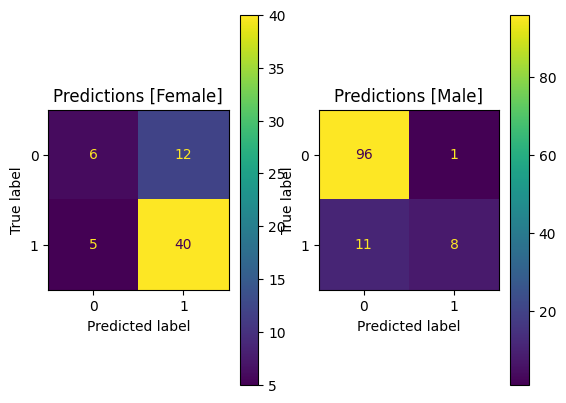

In [22]:
female_df = test_df[test_df['Sex']=="female"]
male_df = test_df[test_df['Sex']=="male"]
fig, ax = plt.subplots(1, 2)
metrics.ConfusionMatrixDisplay.from_predictions(female_df['true'], female_df['pred'], ax = ax[0]);
ax[0].set_title('Predictions [Female]')
metrics.ConfusionMatrixDisplay.from_predictions(male_df['true'], male_df['pred'], ax = ax[1]);
ax[1].set_title('Predictions [Male]')
plt.show()